# Тестирование на нормальном распределении

## 1. Генерация данных

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys

sys.path.append('../metric')
sys.path.append('../util')

import nn
import metrics
import loss
import train_set

In [2]:
n = 5
size = 30
mus= np.array([[-1, 1], [-1, 0], [0, -1], [1, 0], [1, 1]])
sigmas = np.array([[0.5, 0.5], [0.5, 0.5],
                   [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]])
train_xs, test_xs, train_ys, test_ys = train_set.gauss_cls(n, size, 0.3,
                                                           mus, sigmas)
train_len = np.size(train_xs, axis=0)
test_len = np.size(test_xs, axis=0)

## 2. kNN

### 2.1 Классификация

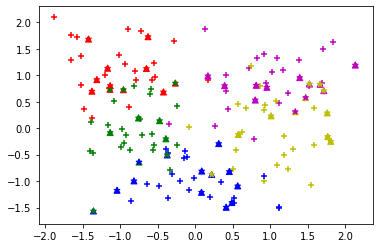

In [3]:
k = 20
color = ['r', 'g', 'b', 'y', 'm']
classes = np.zeros(test_len, dtype=np.int)
for i in range(test_len):
    cls, results = nn.knn(n, k,
                          train_xs, train_ys,
                          test_xs[i, :],
                          metrics.euclidean)
    classes[i] = cls    

def plot(train_xs, train_ys,
         test_xs, test_ys,
         classes, color):
    colors = [color[train_ys[i]] for i in range(train_len)]
    plt.scatter(train_xs[:, 0], train_xs[:, 1], c=colors, marker='+')

    plt.scatter(test_xs[:, 0],
                test_xs[:, 1],
                c=[color[cls] for cls in classes],
                marker='^')

    plt.scatter(test_xs[:, 0],
                test_xs[:, 1],
                c=[color[cls] for cls in test_ys],
                marker='*')
plot(train_xs, train_ys, test_xs, test_ys, classes, color)

In [4]:
loss.empirical_risk_cls(classes, test_ys)

0.26666666666666666

### 2.2 Поиск оптимального k

In [5]:
def a(n, k, xs, ys, u):
    return nn.knn(n, k, xs, ys, u, metrics.euclidean)

opt_k, ks = nn.leave_one_out(n, train_len, a, train_xs, train_ys)

In [6]:
opt_k

7

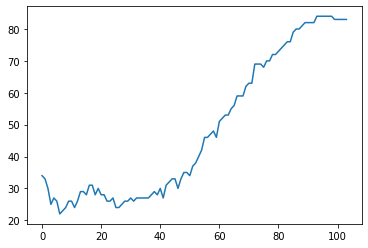

In [7]:
plt.plot(np.arange(0, np.size(ks, axis=0), 1), ks)

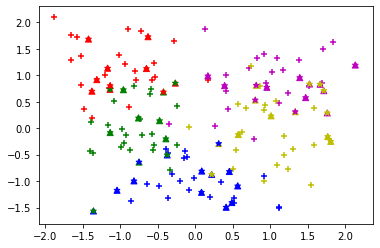

In [8]:
classes = np.zeros(test_len, dtype=np.int)
for i in range(test_len):
    cls, results = nn.knn(n, opt_k,
                          train_xs, train_ys,
                          test_xs[i, :],
                          metrics.euclidean)
    classes[i] = cls

plot(train_xs, train_ys, test_xs, test_ys, classes, color)

In [9]:
loss.empirical_risk_cls(classes, test_ys)

0.33333333333333337

## 3. Метод парзеновского окна

### 3.1 Классификация

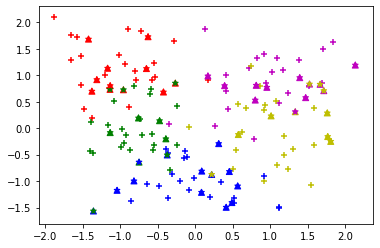

In [10]:
k = 20
classes = np.zeros(test_len, dtype=np.int)
for i in range(test_len):
    cls, results = nn.knn_parzen(n, k,
                                 train_xs, train_ys,
                                 test_xs[i, :],
                                 metrics.euclidean)
    classes[i] = cls

plot(train_xs, train_ys, test_xs, test_ys, classes, color)

In [11]:
loss.empirical_risk_cls(classes, test_ys)

0.24444444444444446

### 3.2 Выбор оптимального k

In [12]:
def a(n, k, xs, ys, u):
    return nn.knn_parzen(n, k, xs, ys, u, metrics.euclidean)

opt_k, ks = nn.leave_one_out(n, train_len - 1, a, train_xs, train_ys)

In [13]:
opt_k

9

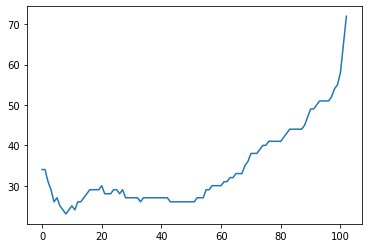

In [14]:
plt.plot(np.arange(0, np.size(ks, axis=0), 1), ks)

In [15]:
classes = np.zeros(test_len, dtype=np.int)
for i in range(test_len):
    cls, results = nn.knn_parzen(n, opt_k,
                                train_xs, train_ys,
                                test_xs[i, :],
                                metrics.euclidean)
    classes[i] = cls

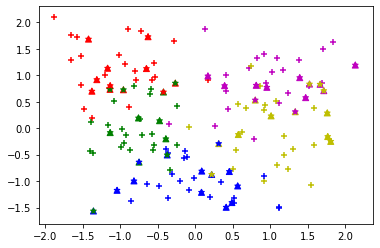

In [16]:
plot(train_xs, train_ys, test_xs, test_ys, classes, color)

In [17]:
loss.empirical_risk_cls(classes, test_ys)

0.3111111111111111

## 4. Отбор эталонов

### 4.1 Отступы

In [18]:
def a(u):
    return nn.knn_parzen(n, opt_k, train_xs, train_ys, u, metrics.euclidean)

margins = nn.margin(n, a, train_xs, train_ys)
margins.sort()

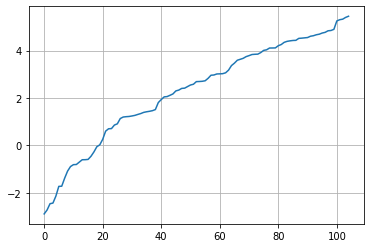

In [19]:
plt.plot(np.arange(np.size(margins, axis=0)), margins)
plt.grid()

### 4.2 Сжатие обучающего множества алгоритмом STOLP

In [20]:
def a(u, k, xs, ys):
    return nn.knn_parzen(n, k, xs, ys, u, metrics.euclidean)

compr_train_xs, compr_train_ys = \
    nn.stolp(n, opt_k, 0, 0.15 * train_len, a, train_xs, train_ys)

Размеры обучающего множества до и после сжатия:

In [21]:
train_len, np.size(compr_train_xs, axis=0)

(105, 25)

Классификация и эмпирический риск:

In [22]:
classes = np.zeros(test_len, dtype=np.int)
for i in range(test_len):
    cls, results = nn.knn_parzen(n, n + 10,
                                compr_train_xs, compr_train_ys,
                                test_xs[i, :],
                                metrics.euclidean)
    classes[i] = cls

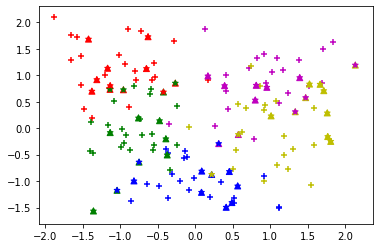

In [23]:
plot(train_xs, train_ys, test_xs, test_ys, classes, color)

In [24]:
loss.empirical_risk_cls(classes, test_ys)

0.26666666666666666